Epoch [1000/50000], Loss: 0.3159
Epoch [2000/50000], Loss: 0.3052
Epoch [3000/50000], Loss: 0.3003
Epoch [4000/50000], Loss: 0.2972
Epoch [5000/50000], Loss: 0.2952
Epoch [6000/50000], Loss: 0.2933
Epoch [7000/50000], Loss: 0.2918
Epoch [8000/50000], Loss: 0.2906
Epoch [9000/50000], Loss: 0.2887
Epoch [10000/50000], Loss: 0.2869
Epoch [11000/50000], Loss: 0.2843
Epoch [12000/50000], Loss: 0.2833
Epoch [13000/50000], Loss: 0.2812
Epoch [14000/50000], Loss: 0.2812
Epoch [15000/50000], Loss: 0.2794
Epoch [16000/50000], Loss: 0.2783
Epoch [17000/50000], Loss: 0.2784
Epoch [18000/50000], Loss: 0.2773
Epoch [19000/50000], Loss: 0.2767
Epoch [20000/50000], Loss: 0.2767
Epoch [21000/50000], Loss: 0.2758
Epoch [22000/50000], Loss: 0.2762
Epoch [23000/50000], Loss: 0.2751
Epoch [24000/50000], Loss: 0.2747
Epoch [25000/50000], Loss: 0.2743
Epoch [26000/50000], Loss: 0.2747
Epoch [27000/50000], Loss: 0.2740
Epoch [28000/50000], Loss: 0.2736
Epoch [29000/50000], Loss: 0.2730
Epoch [30000/50000], Lo

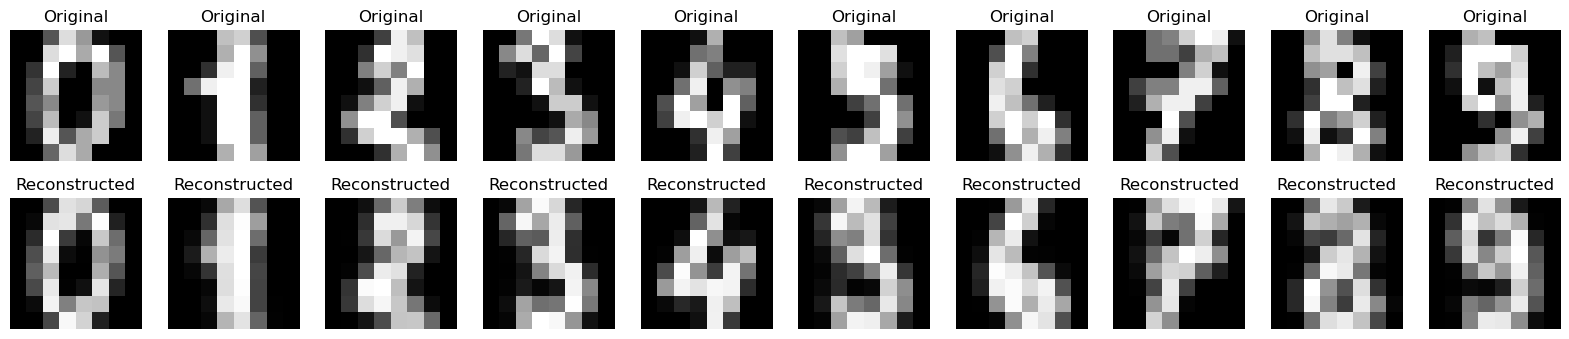

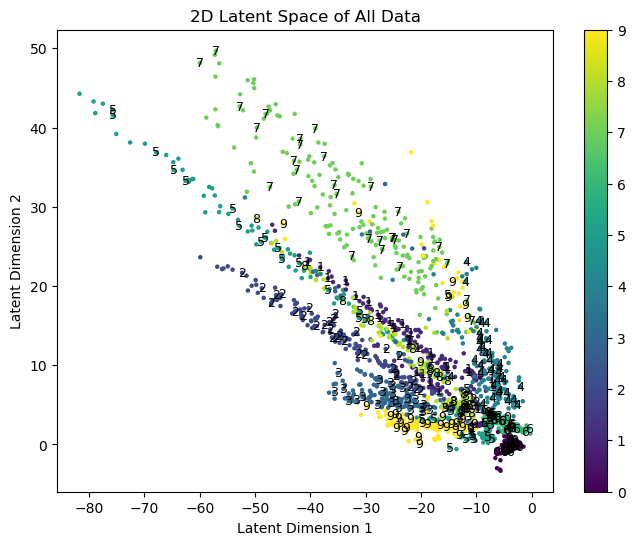

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np


if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")


# Load the MNIST 8x8 dataset from sklearn
digits = load_digits()
data = digits.data / 16.0  # Normalize to range [0, 1]
targets = digits.target

# Convert the data to PyTorch tensors
data_tensor = torch.tensor(data, dtype=torch.float32)

# Autoencoder model definition with more hidden layers in both encoder and decoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(64, 128),  # First hidden layer with 128 units
            nn.ReLU(),
            nn.Linear(128, 64),  # Second hidden layer with 64 units
            nn.ReLU(),
            nn.Linear(64, 32),   # Third hidden layer with 32 units
            nn.ReLU(),
            nn.Linear(32, 16),   # Third hidden layer with 32 units
            nn.ReLU(),
            nn.Linear(16, 2)     # Latent space (2D)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 16),   # First hidden layer after latent space
            nn.ReLU(),
            nn.Linear(16, 32),   # Third hidden layer with 32 units
            nn.ReLU(),
            nn.Linear(32, 64),  # Second hidden layer
            nn.ReLU(),
            nn.Linear(64, 128),  # Third hidden layer
            nn.ReLU(),
            nn.Linear(128, 64),  # Output layer to reconstruct original 64 features
            nn.Sigmoid()  # Sigmoid to keep output in range [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded  # Return both encoded (latent space) and decoded (reconstruction)

# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for normalized input
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the autoencoder using all the data
num_epochs = 10000
batch_size = 512

for epoch in range(num_epochs):
    # Forward pass
    encoded, outputs = model(data_tensor)
    loss = criterion(outputs, data_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the autoencoder by reconstructing the same data (since there's no test set)
with torch.no_grad():
    encoded_data, reconstructed_data = model(data_tensor)

# Visualize original and reconstructed digits
n = 10  # Number of digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(data[i].reshape(8, 8), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_data[i].reshape(8, 8), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()

# Plot the 2D latent space using a scatter plot
encoded_data_np = encoded_data.numpy()
plt.figure(figsize=(8, 6))

# Scatter plot, coloring by target labels
scatter = plt.scatter(encoded_data_np[:, 0], encoded_data_np[:, 1], c=targets, cmap='viridis', s=5)
plt.colorbar(scatter)
plt.title("2D Latent Space of All Data")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")

# Optionally display labels for specific points
indices_to_label = np.random.choice(len(encoded_data_np), size=300, replace=False)  # Select 15 random points to label
for i in indices_to_label:
    plt.text(encoded_data_np[i, 0], encoded_data_np[i, 1], str(targets[i]),
             fontsize=9, color='black', ha='center', va='center')

plt.show()